In [1]:
import os  # For interacting with the file system
import pandas as pd  # For handling dataframes and CSVs
import numpy as np
from elasticsearch import helpers, Elasticsearch
from datetime import datetime
from tqdm import tqdm  # Import tqdm for progress tracking

In [2]:
# Retrieve authentication information for Elasticsearch
elastic_host = "https://localhost"
elastic_port = "9200"
elastic_user = "admin"
elastic_password = "motdepasse"
elastic_ca_path = "C:\\elasticsearch-8.15.2\\config\\certs\\http_ca.crt"

# Connect to Elasticsearch
es = Elasticsearch(
    hosts=[f"{elastic_host}:{elastic_port}"],
    basic_auth=(elastic_user, elastic_password),
    ca_certs=elastic_ca_path,
    verify_certs=True
)
print(es.info())

# Check connection
if es.ping():
    print("Connected to Elasticsearch")
else:
    print("Failed to connect to Elasticsearch")

{'name': 'MSI', 'cluster_name': 'elasticsearch', 'cluster_uuid': 'ylmZI0lnRpa-pP1lwEKJ7A', 'version': {'number': '8.15.2', 'build_flavor': 'default', 'build_type': 'zip', 'build_hash': '98adf7bf6bb69b66ab95b761c9e5aadb0bb059a3', 'build_date': '2024-09-19T10:06:03.564235954Z', 'build_snapshot': False, 'lucene_version': '9.11.1', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'}
Connected to Elasticsearch


In [3]:
def fetch_flows_from_elasticsearch(application_name):
    data = []
    
    # Define the body with a filter on application_name
    body = {
        "query": {
            "match": {
                "application_name": application_name
            }
        }
    }
    
    res = helpers.scan(
                    client=es,
                    scroll='2m',
                    query=body,
                    index="network_flows_fan_encoded_final")
    
    for i in res:
        data.append(i['_source'])
    
    # Converting into a Pandas dataframe
    df = pd.DataFrame(data)
    
    # Print the dataframe
    print(f"Network data : \n{df}")
    return df

In [4]:
df_http = fetch_flows_from_elasticsearch("HTTP")

Network data : 
      application_name  bidirectional_packets  bidirectional_bytes  \
0                 HTTP              -0.309654            -0.208805   
1                 HTTP              -0.320001            -0.209567   
2                 HTTP              -0.309654            -0.208805   
3                 HTTP              -0.309654            -0.208805   
4                 HTTP              -0.320001            -0.209567   
...                ...                    ...                  ...   
95280             HTTP              -0.320001            -0.209567   
95281             HTTP              -0.320001            -0.209567   
95282             HTTP              -0.309654            -0.208805   
95283             HTTP              -0.309654            -0.208805   
95284             HTTP              -0.371737            -0.220867   

       bidirectional_mean_ps  bidirectional_stddev_ps  src2dst_mean_ps  \
0                   0.568330                 0.901425        -0.05223

In [5]:
from sklearn.model_selection import train_test_split, StratifiedKFold

# Assuming 'application_name' is the target column in df_http for stratification
# Separate features and target
X = df_http.drop(columns=["label", "application_name"])  # Features
y = df_http["label"]  # Target variable

# Step 1: Split data into 80% train and 20% test, with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [6]:
df_http["label"].value_counts()

label
0    92839
1     2446
Name: count, dtype: int64

In [7]:
y_test.value_counts()

label
0    18568
1      489
Name: count, dtype: int64

In [8]:
# Step 2: Partition X_train and y_train into 5 stratified subsets
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_subsets = []

for train_index, val_index in skf.split(X_train, y_train):
    # Create subsets S1, S2, S3, S4, and S5 as (X, y) pairs
    subset_X, subset_y = X_train.iloc[train_index], y_train.iloc[train_index]
    train_subsets.append((subset_X, subset_y))

In [9]:
# Optional: Print summary of the subsets
print(f"Test Set Size: {len(X_test)}")
for i, (subset_X, subset_y) in enumerate(train_subsets, start=1):
    print(f"Subset S{i} Size: {len(subset_X)}")

Test Set Size: 19057
Subset S1 Size: 60982
Subset S2 Size: 60982
Subset S3 Size: 60982
Subset S4 Size: 60983
Subset S5 Size: 60983


# KNN model

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

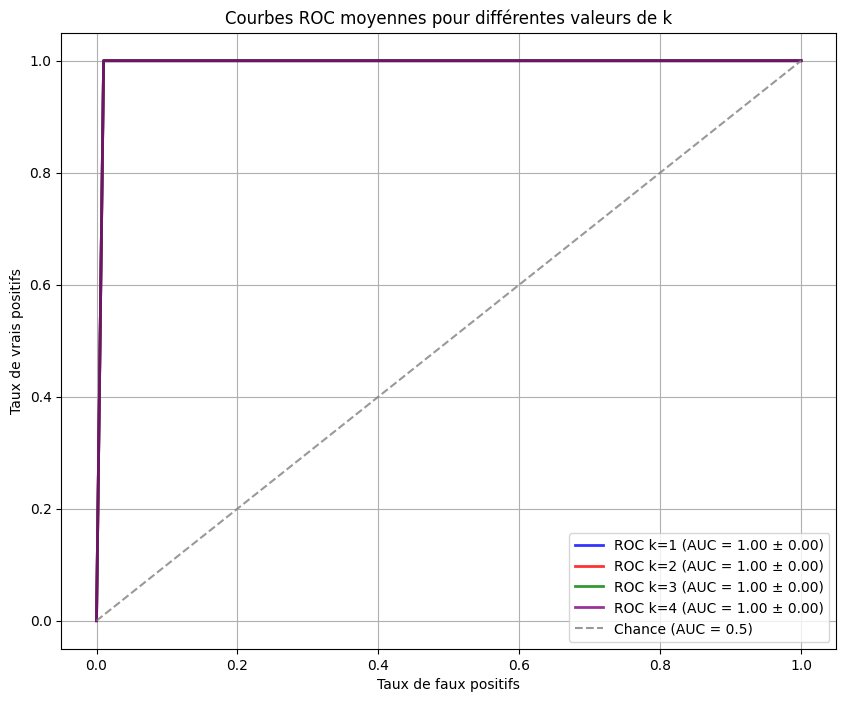


Résultats pour k=1:
AUC moyen: 1.0000
Accuracy moyen: 1.0000
Precision moyen: 1.0000
Recall moyen: 1.0000
F1-score moyen: 1.0000

Résultats pour k=2:
AUC moyen: 1.0000
Accuracy moyen: 1.0000
Precision moyen: 1.0000
Recall moyen: 1.0000
F1-score moyen: 1.0000

Résultats pour k=3:
AUC moyen: 1.0000
Accuracy moyen: 1.0000
Precision moyen: 1.0000
Recall moyen: 1.0000
F1-score moyen: 1.0000

Résultats pour k=4:
AUC moyen: 1.0000
Accuracy moyen: 1.0000
Precision moyen: 1.0000
Recall moyen: 1.0000
F1-score moyen: 1.0000

Meilleur k trouvé: 1
Meilleur AUC: 1.0000


In [10]:
# Initialize an empty list to hold evaluation metrics for each k
results = []

# Créer une figure pour les courbes ROC
plt.figure(figsize=(10, 8))

# Couleurs différentes pour chaque k
colors = ['blue', 'red', 'green', 'purple']

for k_idx, k in enumerate(range(1,5)):
    # Initialize an empty list to hold evaluation metrics for each T_1
    local_results = []
    
    # Listes pour stocker les taux moyens de faux positifs et vrais positifs
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    
    # Run 5 tasks, each with a different S_i for testing and T_i for training
    for i in range(5):
        # S_i is the i-th subset used for testing
        X_test_task = train_subsets[i][0]
        y_test_task = train_subsets[i][1]
        
        # T_i is the union of all subsets except S_i
        X_train_task = pd.concat([train_subsets[j][0] for j in range(5) if j != i])
        y_train_task = pd.concat([train_subsets[j][1] for j in range(5) if j != i])
        
        # Initialize the KNN classifier
        knn = KNeighborsClassifier(n_neighbors=k)
        
        # Fit the model on T_i
        knn.fit(X_train_task, y_train_task)
        
        # Predict probabilities and classes
        y_pred_proba = knn.predict_proba(X_test_task)[:, 1]
        y_pred = knn.predict(X_test_task)
        
        # Calculer la courbe ROC
        fpr, tpr, _ = roc_curve(y_test_task, y_pred_proba)
        
        # Interpoler pour avoir des points uniformes
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        
        # Calculer l'AUC pour ce fold
        auc = roc_auc_score(y_test_task, y_pred_proba)
        aucs.append(auc)
        
        # Calculate other evaluation metrics
        accuracy = accuracy_score(y_test_task, y_pred)
        precision = precision_score(y_test_task, y_pred, pos_label=1)
        recall = recall_score(y_test_task, y_pred, pos_label=1)
        f1 = f1_score(y_test_task, y_pred, pos_label=1)
        
        # Store the local results for this Task i
        local_results.append({
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "AUC": auc
        })
    
    # Calculer la courbe ROC moyenne
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    
    # Tracer la courbe ROC moyenne
    plt.plot(mean_fpr, mean_tpr, color=colors[k_idx],
             label=f'ROC k={k} (AUC = {mean_auc:.2f} ± {std_auc:.2f})',
             lw=2, alpha=0.8)
    
    # Calculate averages for other metrics
    avg_accuracy = sum(d["Accuracy"] for d in local_results) / 5
    avg_precision = sum(d["Precision"] for d in local_results) / 5
    avg_recall = sum(d["Recall"] for d in local_results) / 5
    avg_f1 = sum(d["F1 Score"] for d in local_results) / 5
    
    # Append results
    results.append({
        "k": k,
        "Average AUC": mean_auc,
        "Average Accuracy": avg_accuracy,
        "Average Precision": avg_precision,
        "Average Recall": avg_recall,
        "Average F1 Score": avg_f1
    })

# Finaliser le graphique ROC
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.8,
         label='Chance (AUC = 0.5)')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbes ROC moyennes pour différentes valeurs de k')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Afficher les résultats pour chaque k
for result in results:
    print(f"\nRésultats pour k={result['k']}:")
    print(f"AUC moyen: {result['Average AUC']:.4f}")
    print(f"Accuracy moyen: {result['Average Accuracy']:.4f}")
    print(f"Precision moyen: {result['Average Precision']:.4f}")
    print(f"Recall moyen: {result['Average Recall']:.4f}")
    print(f"F1-score moyen: {result['Average F1 Score']:.4f}")

# Trouver le meilleur k basé sur l'AUC
best_k = max(results, key=lambda x: x['Average AUC'])
print(f"\nMeilleur k trouvé: {best_k['k']}")
print(f"Meilleur AUC: {best_k['Average AUC']:.4f}")

#### Le calcul des métriques au sein du train data-set n'est pas pertinent ici (100% à chaque métrique), évaluons le model KNN en l'entrainant sur l'ensemble des données d'entraintement (80% des données initiales) pour chaque k et le testant sur l'ensemble de test initial (20% des données initiales, non utilisés pour l'entraintement).

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

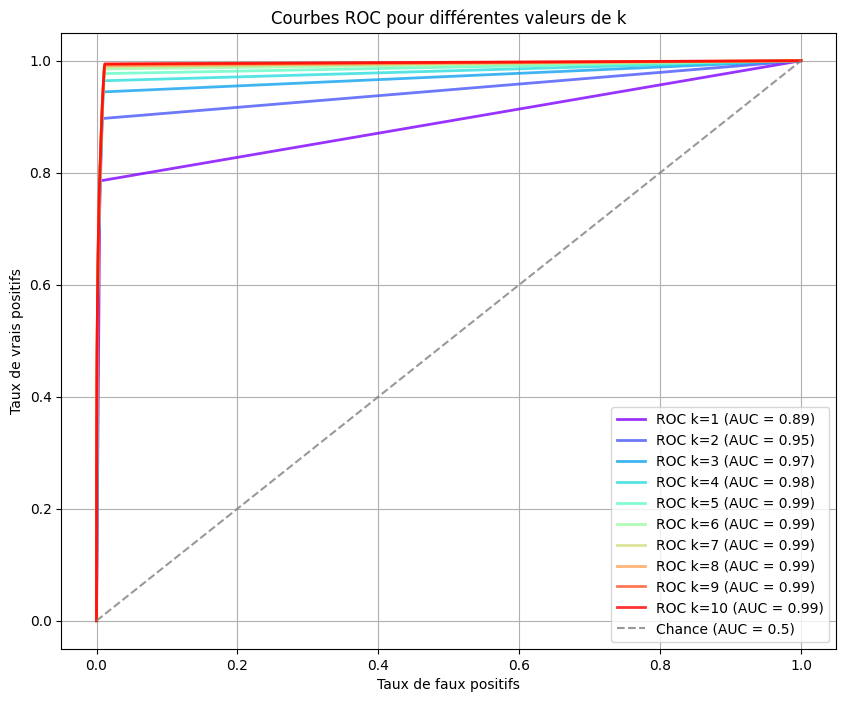


Results for k = 1:
Average AUC: 0.8903 ± 0.0130
Average Accuracy: 0.9898 ± 0.0009
Average Precision: 0.8096 ± 0.0126
Average Recall: 0.7854 ± 0.0258
Average F1 Score: 0.7972 ± 0.0190

Results for k = 2:
Average AUC: 0.9459 ± 0.0099
Average Accuracy: 0.9887 ± 0.0007
Average Precision: 0.8743 ± 0.0171
Average Recall: 0.6541 ± 0.0163
Average F1 Score: 0.7483 ± 0.0164

Results for k = 3:
Average AUC: 0.9697 ± 0.0054
Average Accuracy: 0.9900 ± 0.0012
Average Precision: 0.8101 ± 0.0203
Average Recall: 0.7982 ± 0.0338
Average F1 Score: 0.8039 ± 0.0251

Results for k = 4:
Average AUC: 0.9796 ± 0.0056
Average Accuracy: 0.9899 ± 0.0009
Average Precision: 0.8592 ± 0.0162
Average Recall: 0.7241 ± 0.0269
Average F1 Score: 0.7857 ± 0.0206

Results for k = 5:
Average AUC: 0.9860 ± 0.0045
Average Accuracy: 0.9901 ± 0.0009
Average Precision: 0.8081 ± 0.0223
Average Recall: 0.8089 ± 0.0147
Average F1 Score: 0.8084 ± 0.0156

Results for k = 6:
Average AUC: 0.9901 ± 0.0017
Average Accuracy: 0.9895 ± 0.00

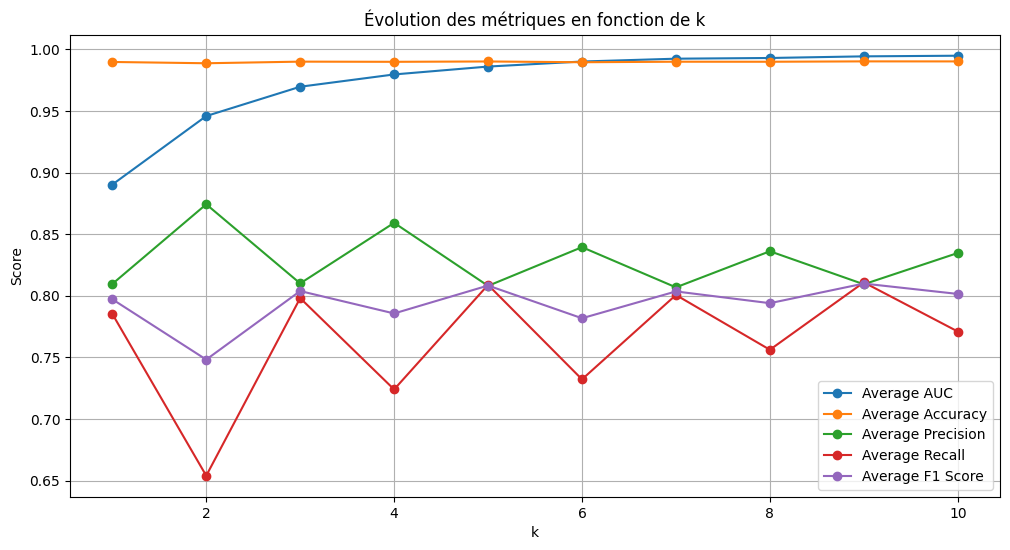

In [12]:
# Initialize an empty list to hold evaluation metrics for each k
knn_results_by_k = []

# Créer une figure pour les courbes ROC
plt.figure(figsize=(10, 8))
colors = plt.cm.rainbow(np.linspace(0, 1, 10))  # 8 couleurs différentes pour k=1 à 10

# Range of k values to test
for idx, k in enumerate(range(1, 11)):
    # Initialize the k-NN classifier with the current k value
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Perform 5-fold cross-validation for different metrics
    accuracy_scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    precision_scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='precision')
    recall_scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='recall')
    f1_scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='f1')
    roc_auc_scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='roc_auc')
    
    # Get probability predictions for ROC curve
    y_pred_proba = cross_val_predict(knn, X_train, y_train, cv=5, method='predict_proba')
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_train, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, color=colors[idx],
             label=f'ROC k={k} (AUC = {roc_auc:.2f})',
             lw=2, alpha=0.8)
    
    # Calculate averages
    avg_accuracy = np.mean(accuracy_scores)
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)
    avg_auc = np.mean(roc_auc_scores)
    
    # Calculate standard deviations
    std_accuracy = np.std(accuracy_scores)
    std_precision = np.std(precision_scores)
    std_recall = np.std(recall_scores)
    std_f1 = np.std(f1_scores)
    std_auc = np.std(roc_auc_scores)
    
    # Store the results for this k
    knn_results_by_k.append({
        "k": k,
        "Average AUC": avg_auc,
        "Std AUC": std_auc,
        "Average Accuracy": avg_accuracy,
        "Std Accuracy": std_accuracy,
        "Average Precision": avg_precision,
        "Std Precision": std_precision,
        "Average Recall": avg_recall,
        "Std Recall": std_recall,
        "Average F1 Score": avg_f1,
        "Std F1 Score": std_f1
    })

# Finaliser le graphique ROC
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.8,
         label='Chance (AUC = 0.5)')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbes ROC pour différentes valeurs de k')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print out the results for each k
for result in knn_results_by_k:
    print(f"\nResults for k = {result['k']}:")
    print(f"Average AUC: {result['Average AUC']:.4f} ± {result['Std AUC']:.4f}")
    print(f"Average Accuracy: {result['Average Accuracy']:.4f} ± {result['Std Accuracy']:.4f}")
    print(f"Average Precision: {result['Average Precision']:.4f} ± {result['Std Precision']:.4f}")
    print(f"Average Recall: {result['Average Recall']:.4f} ± {result['Std Recall']:.4f}")
    print(f"Average F1 Score: {result['Average F1 Score']:.4f} ± {result['Std F1 Score']:.4f}")

# Find best k based on AUC
best_k = max(knn_results_by_k, key=lambda x: x['Average AUC'])
print(f"\nBest k found: {best_k['k']}")
print(f"Best AUC: {best_k['Average AUC']:.4f} ± {best_k['Std AUC']:.4f}")

# Visualiser l'évolution des métriques en fonction de k
metrics = ['Average AUC', 'Average Accuracy', 'Average Precision', 'Average Recall', 'Average F1 Score']
plt.figure(figsize=(12, 6))
for metric in metrics:
    plt.plot([result['k'] for result in knn_results_by_k],
             [result[metric] for result in knn_results_by_k],
             marker='o',
             label=metric)

plt.xlabel('k')
plt.ylabel('Score')
plt.title('Évolution des métriques en fonction de k')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# On force le k pour le combo precision/recall qu'on souhaite
best_k = {"k": 9}


=== VALIDATION FINALE SUR L'ENSEMBLE DE TEST ===

Résultats sur l'ensemble de test:
Accuracy: 0.9903
Precision: 0.8193
Recall: 0.7975
F1-score: 0.8083
AUC-ROC: 0.9927

Rapport de classification détaillé:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     18568
           1       0.82      0.80      0.81       489

    accuracy                           0.99     19057
   macro avg       0.91      0.90      0.90     19057
weighted avg       0.99      0.99      0.99     19057



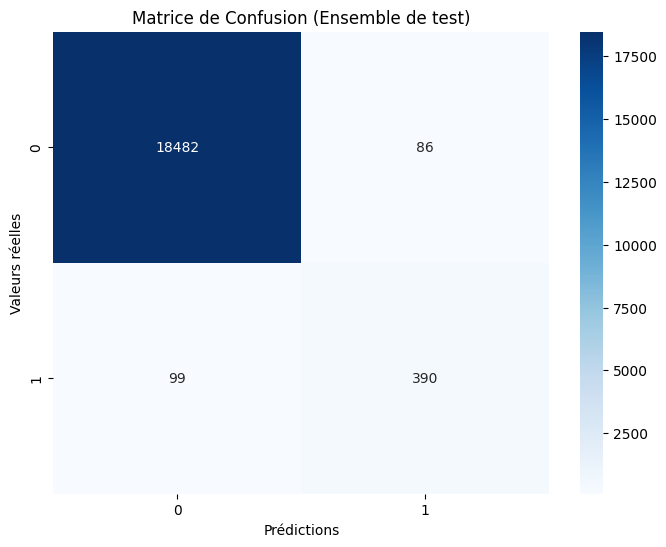

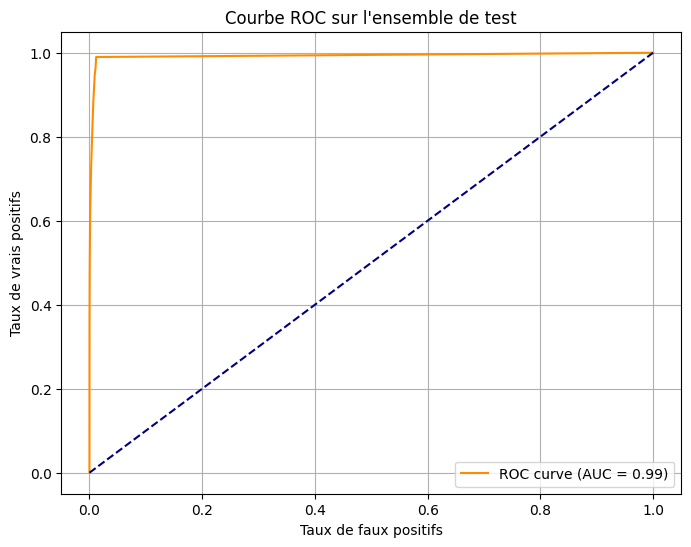

In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# =============== VALIDATION FINALE ===============
print("\n=== VALIDATION FINALE SUR L'ENSEMBLE DE TEST ===")

# Initialiser le modèle k-NN classifier avec le meilleur k
best_knn = KNeighborsClassifier(n_neighbors=best_k["k"])

# Entraîner le modèle
best_knn.fit(X_train, y_train)

# Prédire sur l'ensemble de test
y_pred = best_knn.predict(X_test)
y_pred_proba = best_knn.predict_proba(X_test)

# Calculer les métriques d'évaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

# Calculer la courbe ROC et l'AUC pour l'ensemble de test
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc_test = auc(fpr_test, tpr_test)

# Afficher les résultats de validation
print(f"\nRésultats sur l'ensemble de test:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc_test:.4f}")

# Afficher le rapport de classification détaillé
print("\nRapport de classification détaillé:")
print(classification_report(y_test, y_pred))

# Créer et afficher la matrice de confusion
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion (Ensemble de test)')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.show()

# Tracer la courbe ROC finale sur l'ensemble de test
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='darkorange',
         label=f'ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC sur l\'ensemble de test')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Naive Bayes

In [15]:
train_subsets_NB = []

X_train_NB = X_train.astype(float)  # Convert boolean to float (or int) type
X_test_NB = X_test.astype(float)    # Same for X_test

X_train_NB = X_train_NB - X_train_NB.min()  # Shift all values to be positive
X_test_NB = X_test_NB - X_test_NB.min()  # Shift all values to be positive

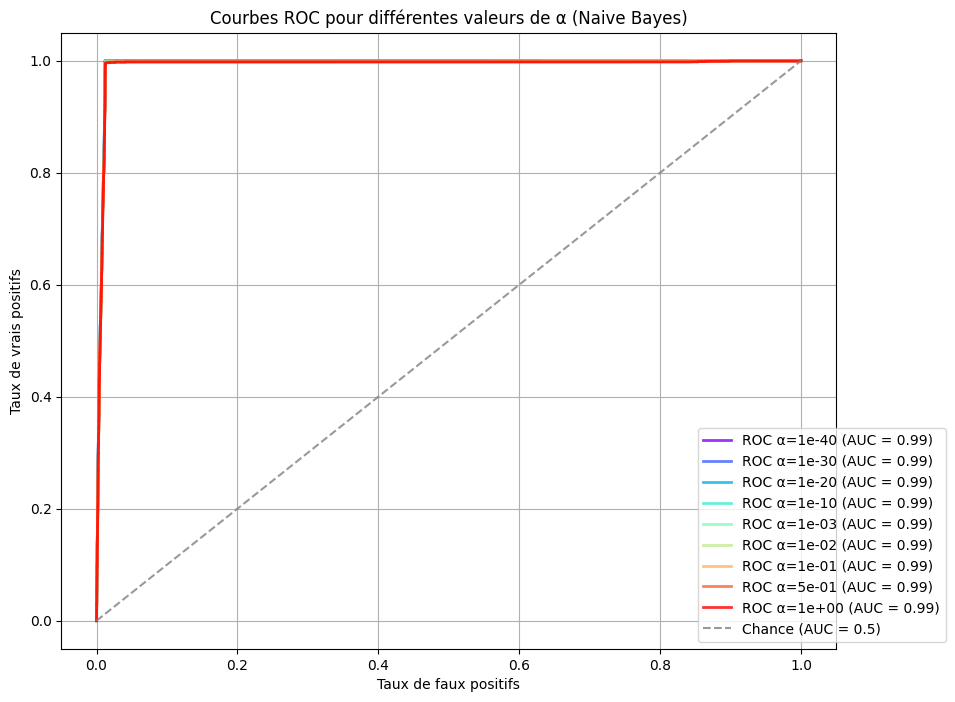


Results for α = 1e-40:
Average AUC: 0.9943 ± 0.0004
Average Accuracy: 0.9868 ± 0.0012
Average Precision: 0.6745 ± 0.0189
Average Recall: 0.9423 ± 0.0162
Average F1 Score: 0.7861 ± 0.0170

Results for α = 1e-30:
Average AUC: 0.9943 ± 0.0004
Average Accuracy: 0.9868 ± 0.0012
Average Precision: 0.6745 ± 0.0189
Average Recall: 0.9423 ± 0.0162
Average F1 Score: 0.7861 ± 0.0170

Results for α = 1e-20:
Average AUC: 0.9943 ± 0.0004
Average Accuracy: 0.9868 ± 0.0011
Average Precision: 0.6743 ± 0.0185
Average Recall: 0.9423 ± 0.0162
Average F1 Score: 0.7860 ± 0.0167

Results for α = 1e-10:
Average AUC: 0.9943 ± 0.0004
Average Accuracy: 0.9867 ± 0.0010
Average Precision: 0.6728 ± 0.0169
Average Recall: 0.9423 ± 0.0162
Average F1 Score: 0.7849 ± 0.0156

Results for α = 1e-03:
Average AUC: 0.9933 ± 0.0011
Average Accuracy: 0.9867 ± 0.0011
Average Precision: 0.6718 ± 0.0175
Average Recall: 0.9423 ± 0.0162
Average F1 Score: 0.7843 ± 0.0160

Results for α = 1e-02:
Average AUC: 0.9928 ± 0.0012
Average

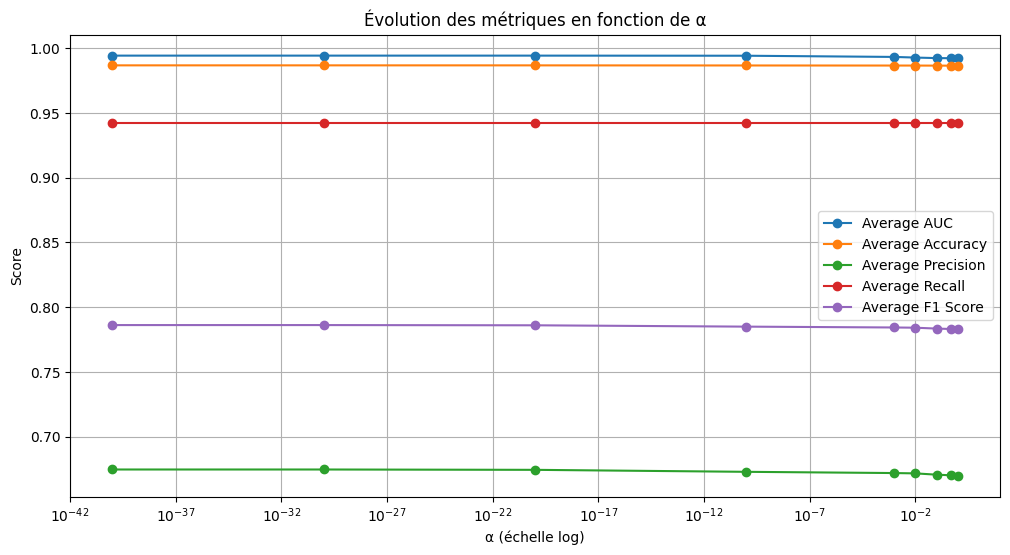

In [16]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Initialize an empty list to hold evaluation metrics for each alpha
nb_results_by_alpha = []

# Créer une figure pour les courbes ROC
plt.figure(figsize=(10, 8))
alpha_values = [1e-40, 1e-30, 1e-20, 1e-10, 0.001, 0.01, 0.1, 0.5, 1.0]
colors = plt.cm.rainbow(np.linspace(0, 1, len(alpha_values)))

# Test different alpha values
for idx, alpha in enumerate(alpha_values):
    # Initialize the Naive Bayes classifier with the current alpha value
    nb = MultinomialNB(alpha=alpha)
    
    # Perform 5-fold cross-validation for different metrics
    accuracy_scores = cross_val_score(nb, X_train_NB, y_train, cv=5, scoring='accuracy')
    precision_scores = cross_val_score(nb, X_train_NB, y_train, cv=5, scoring='precision')
    recall_scores = cross_val_score(nb, X_train_NB, y_train, cv=5, scoring='recall')
    f1_scores = cross_val_score(nb, X_train_NB, y_train, cv=5, scoring='f1')
    roc_auc_scores = cross_val_score(nb, X_train_NB, y_train, cv=5, scoring='roc_auc')
    
    # Get probability predictions for ROC curve
    y_pred_proba = cross_val_predict(nb, X_train_NB, y_train, cv=5, method='predict_proba')
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_train, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, color=colors[idx],
             label=f'ROC α={alpha:.0e} (AUC = {roc_auc:.2f})',
             lw=2, alpha=0.8)
    
    # Calculate averages
    avg_accuracy = np.mean(accuracy_scores)
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)
    avg_auc = np.mean(roc_auc_scores)
    
    # Calculate standard deviations
    std_accuracy = np.std(accuracy_scores)
    std_precision = np.std(precision_scores)
    std_recall = np.std(recall_scores)
    std_f1 = np.std(f1_scores)
    std_auc = np.std(roc_auc_scores)
    
    # Store the results for this alpha
    nb_results_by_alpha.append({
        "alpha": alpha,
        "Average AUC": avg_auc,
        "Std AUC": std_auc,
        "Average Accuracy": avg_accuracy,
        "Std Accuracy": std_accuracy,
        "Average Precision": avg_precision,
        "Std Precision": std_precision,
        "Average Recall": avg_recall,
        "Std Recall": std_recall,
        "Average F1 Score": avg_f1,
        "Std F1 Score": std_f1
    })

# Finaliser le graphique ROC
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.8,
         label='Chance (AUC = 0.5)')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbes ROC pour différentes valeurs de α (Naive Bayes)')
plt.legend(loc='lower right', bbox_to_anchor=(1.15, 0))
plt.grid(True)
plt.show()

# Print out the results for each alpha
for result in nb_results_by_alpha:
    print(f"\nResults for α = {result['alpha']:.0e}:")
    print(f"Average AUC: {result['Average AUC']:.4f} ± {result['Std AUC']:.4f}")
    print(f"Average Accuracy: {result['Average Accuracy']:.4f} ± {result['Std Accuracy']:.4f}")
    print(f"Average Precision: {result['Average Precision']:.4f} ± {result['Std Precision']:.4f}")
    print(f"Average Recall: {result['Average Recall']:.4f} ± {result['Std Recall']:.4f}")
    print(f"Average F1 Score: {result['Average F1 Score']:.4f} ± {result['Std F1 Score']:.4f}")

# Find best alpha based on AUC
best_alpha = max(nb_results_by_alpha, key=lambda x: x['Average AUC'])
print(f"\nBest α found: {best_alpha['alpha']:.0e}")
print(f"Best AUC: {best_alpha['Average AUC']:.4f} ± {best_alpha['Std AUC']:.4f}")

# Visualiser l'évolution des métriques en fonction de alpha
metrics = ['Average AUC', 'Average Accuracy', 'Average Precision', 'Average Recall', 'Average F1 Score']
plt.figure(figsize=(12, 6))
for metric in metrics:
    plt.plot([result['alpha'] for result in nb_results_by_alpha],
             [result[metric] for result in nb_results_by_alpha],
             marker='o',
             label=metric)

plt.xscale('log')  # Échelle logarithmique pour alpha
plt.xlabel('α (échelle log)')
plt.ylabel('Score')
plt.title('Évolution des métriques en fonction de α')
plt.legend()
plt.grid(True)
plt.show()


=== VALIDATION FINALE SUR L'ENSEMBLE DE TEST ===

Résultats sur l'ensemble de test:
Accuracy: 0.9866
Precision: 0.6721
Recall: 0.9305
F1-score: 0.7804
AUC-ROC: 0.9943

Rapport de classification détaillé:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     18568
           1       0.67      0.93      0.78       489

    accuracy                           0.99     19057
   macro avg       0.84      0.96      0.89     19057
weighted avg       0.99      0.99      0.99     19057



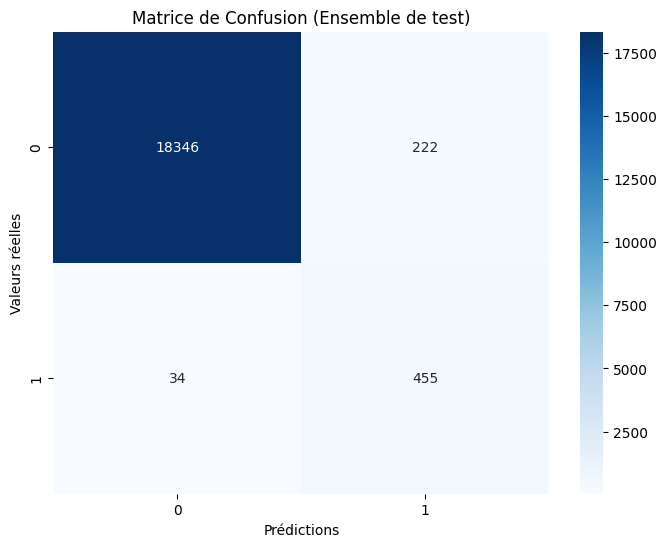

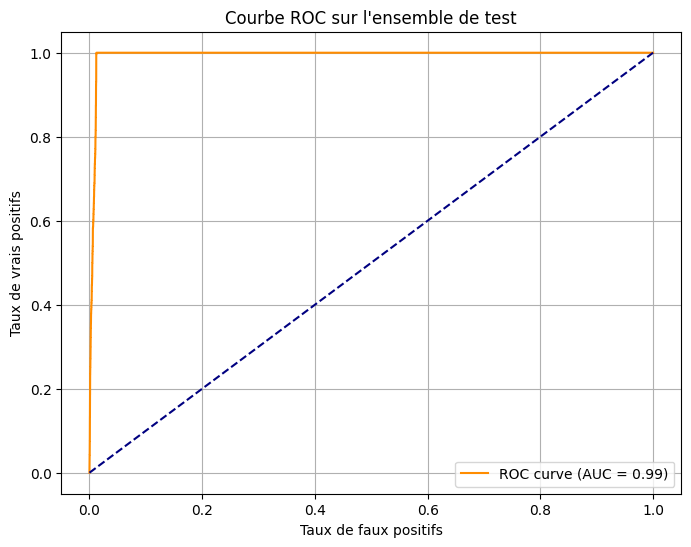

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# =============== VALIDATION FINALE ===============
print("\n=== VALIDATION FINALE SUR L'ENSEMBLE DE TEST ===")

# Initialiser le modèle Naive Bayes Multinomial avec le meilleur alpha
best_nb = MultinomialNB(alpha=best_alpha['alpha'])

# Entraîner le modèle
best_nb.fit(X_train_NB, y_train)

# Prédire sur l'ensemble de test
y_pred = best_nb.predict(X_test_NB)
y_pred_proba = best_nb.predict_proba(X_test_NB)

# Calculer les métriques d'évaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

# Calculer la courbe ROC et l'AUC pour l'ensemble de test
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc_test = auc(fpr_test, tpr_test)

# Afficher les résultats de validation
print(f"\nRésultats sur l'ensemble de test:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc_test:.4f}")

# Afficher le rapport de classification détaillé
print("\nRapport de classification détaillé:")
print(classification_report(y_test, y_pred))

# Créer et afficher la matrice de confusion
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion (Ensemble de test)')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.show()

# Tracer la courbe ROC finale sur l'ensemble de test
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='darkorange',
         label=f'ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC sur l\'ensemble de test')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# RandomForest

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

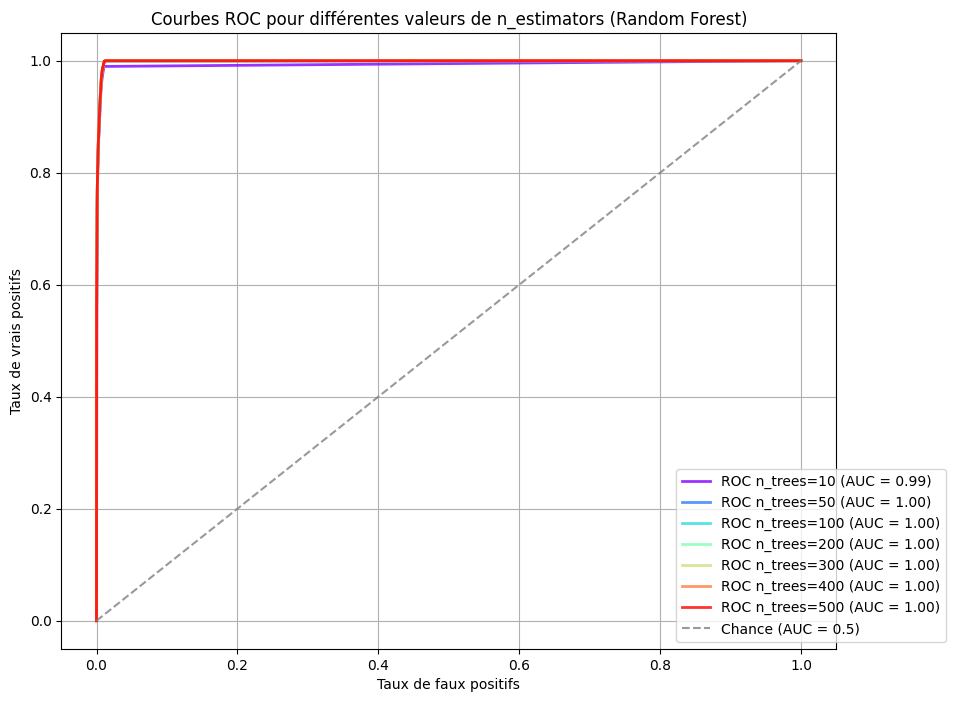


Results for n_estimators = 10:
Average AUC: 0.9936 ± 0.0035
Average Accuracy: 0.9934 ± 0.0009
Average Precision: 0.8833 ± 0.0135
Average Recall: 0.8559 ± 0.0234
Average F1 Score: 0.8693 ± 0.0185

Results for n_estimators = 50:
Average AUC: 0.9986 ± 0.0007
Average Accuracy: 0.9934 ± 0.0008
Average Precision: 0.8741 ± 0.0171
Average Recall: 0.8682 ± 0.0134
Average F1 Score: 0.8711 ± 0.0148

Results for n_estimators = 100:
Average AUC: 0.9987 ± 0.0007
Average Accuracy: 0.9937 ± 0.0008
Average Precision: 0.8771 ± 0.0179
Average Recall: 0.8784 ± 0.0126
Average F1 Score: 0.8778 ± 0.0152

Results for n_estimators = 200:
Average AUC: 0.9989 ± 0.0002
Average Accuracy: 0.9937 ± 0.0007
Average Precision: 0.8750 ± 0.0160
Average Recall: 0.8789 ± 0.0136
Average F1 Score: 0.8769 ± 0.0142

Results for n_estimators = 300:
Average AUC: 0.9989 ± 0.0002
Average Accuracy: 0.9936 ± 0.0008
Average Precision: 0.8741 ± 0.0170
Average Recall: 0.8758 ± 0.0152
Average F1 Score: 0.8749 ± 0.0158

Results for n_es

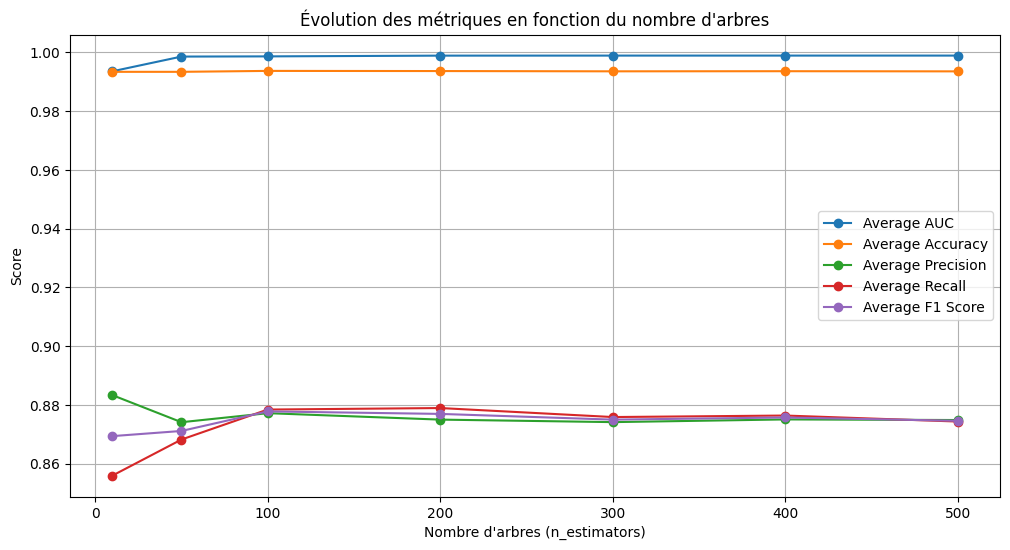

In [27]:
# Initialize an empty list to hold evaluation metrics for each n_estimators
rf_results = []

# Créer une figure pour les courbes ROC
plt.figure(figsize=(10, 8))
n_estimators_values = [10, 50, 100, 200, 300, 400, 500]
colors = plt.cm.rainbow(np.linspace(0, 1, len(n_estimators_values)))

# Test different n_estimators values
for idx, n_trees in enumerate(n_estimators_values):
    # Initialize the Random Forest classifier
    rf = RandomForestClassifier(n_estimators=n_trees, 
                              random_state=42,
                              n_jobs=-1)  # Utiliser tous les processeurs
    
    # Perform 5-fold cross-validation for different metrics
    accuracy_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
    precision_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='precision')
    recall_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='recall')
    f1_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='f1')
    roc_auc_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc')
    
    # Get probability predictions for ROC curve
    y_pred_proba = cross_val_predict(rf, X_train, y_train, cv=5, method='predict_proba')
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_train, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, color=colors[idx],
             label=f'ROC n_trees={n_trees} (AUC = {roc_auc:.2f})',
             lw=2, alpha=0.8)
    
    # Calculate averages and standard deviations
    avg_accuracy = np.mean(accuracy_scores)
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)
    avg_auc = np.mean(roc_auc_scores)
    
    std_accuracy = np.std(accuracy_scores)
    std_precision = np.std(precision_scores)
    std_recall = np.std(recall_scores)
    std_f1 = np.std(f1_scores)
    std_auc = np.std(roc_auc_scores)
    
    # Store the results
    rf_results.append({
        "n_estimators": n_trees,
        "Average AUC": avg_auc,
        "Std AUC": std_auc,
        "Average Accuracy": avg_accuracy,
        "Std Accuracy": std_accuracy,
        "Average Precision": avg_precision,
        "Std Precision": std_precision,
        "Average Recall": avg_recall,
        "Std Recall": std_recall,
        "Average F1 Score": avg_f1,
        "Std F1 Score": std_f1
    })

# Finaliser le graphique ROC
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.8,
         label='Chance (AUC = 0.5)')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbes ROC pour différentes valeurs de n_estimators (Random Forest)')
plt.legend(loc='lower right', bbox_to_anchor=(1.15, 0))
plt.grid(True)
plt.show()

# Print out the results for each n_estimators
for result in rf_results:
    print(f"\nResults for n_estimators = {result['n_estimators']}:")
    print(f"Average AUC: {result['Average AUC']:.4f} ± {result['Std AUC']:.4f}")
    print(f"Average Accuracy: {result['Average Accuracy']:.4f} ± {result['Std Accuracy']:.4f}")
    print(f"Average Precision: {result['Average Precision']:.4f} ± {result['Std Precision']:.4f}")
    print(f"Average Recall: {result['Average Recall']:.4f} ± {result['Std Recall']:.4f}")
    print(f"Average F1 Score: {result['Average F1 Score']:.4f} ± {result['Std F1 Score']:.4f}")

# Find best n_estimators based on AUC
best_result = max(rf_results, key=lambda x: x['Average AUC'])
print(f"\nBest n_estimators found: {best_result['n_estimators']}")
print(f"Best AUC: {best_result['Average AUC']:.4f} ± {best_result['Std AUC']:.4f}")

# Visualiser l'évolution des métriques en fonction de n_estimators
metrics = ['Average AUC', 'Average Accuracy', 'Average Precision', 'Average Recall', 'Average F1 Score']
plt.figure(figsize=(12, 6))
for metric in metrics:
    plt.plot([result['n_estimators'] for result in rf_results],
             [result[metric] for result in rf_results],
             marker='o',
             label=metric)

plt.xlabel('Nombre d\'arbres (n_estimators)')
plt.ylabel('Score')
plt.title('Évolution des métriques en fonction du nombre d\'arbres')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# we force choosing 200, the best recall
best_result['n_estimators'] = 200


=== VALIDATION FINALE SUR L'ENSEMBLE DE TEST ===

Résultats sur l'ensemble de test:
Accuracy: 0.9943
Precision: 0.9027
Recall: 0.8732
F1-score: 0.8877
AUC-ROC: 0.9990

Rapport de classification détaillé:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18568
           1       0.90      0.87      0.89       489

    accuracy                           0.99     19057
   macro avg       0.95      0.94      0.94     19057
weighted avg       0.99      0.99      0.99     19057



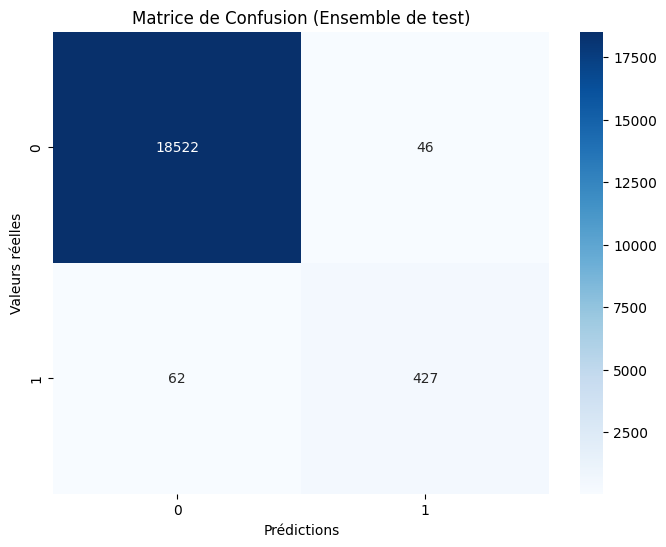

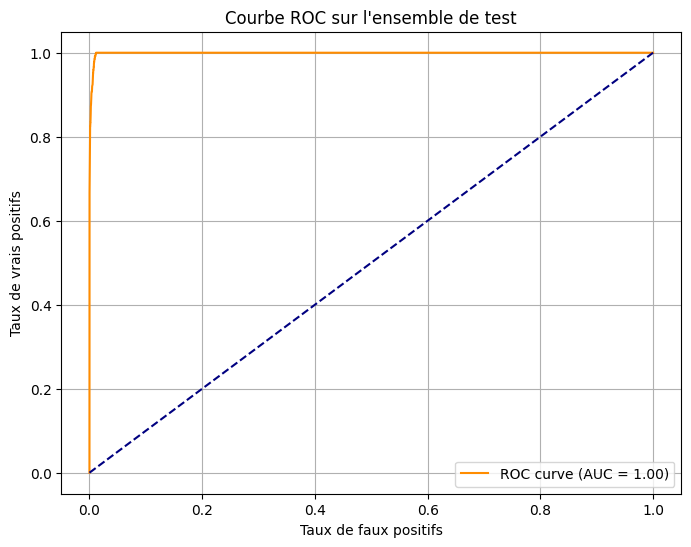

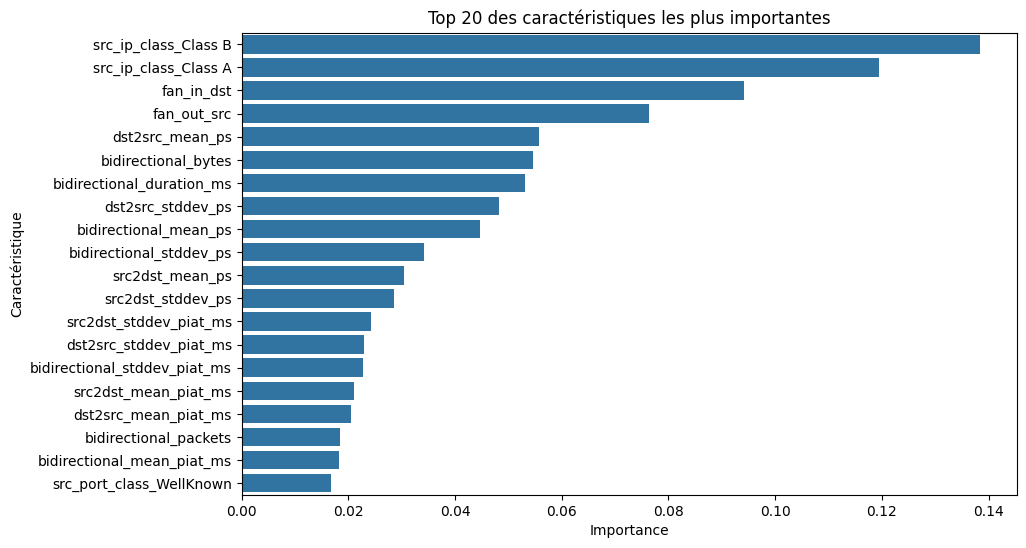

In [29]:
# =============== VALIDATION FINALE ===============
print("\n=== VALIDATION FINALE SUR L'ENSEMBLE DE TEST ===")

# Initialiser le modèle Random Forest avec le meilleur n_estimators
best_rf = RandomForestClassifier(n_estimators=best_result['n_estimators'],
                                random_state=42,
                                n_jobs=-1)

# Entraîner le modèle
best_rf.fit(X_train, y_train)

# Prédire sur l'ensemble de test
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)

# Calculer les métriques d'évaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

# Calculer la courbe ROC et l'AUC pour l'ensemble de test
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc_test = auc(fpr_test, tpr_test)

# Afficher les résultats de validation
print(f"\nRésultats sur l'ensemble de test:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc_test:.4f}")

# Afficher le rapport de classification détaillé
print("\nRapport de classification détaillé:")
print(classification_report(y_test, y_pred))

# Créer et afficher la matrice de confusion
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion (Ensemble de test)')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.show()

# Tracer la courbe ROC finale sur l'ensemble de test
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='darkorange',
         label=f'ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC sur l\'ensemble de test')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Afficher l'importance des caractéristiques
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_rf.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 des caractéristiques les plus importantes')
plt.xlabel('Importance')
plt.ylabel('Caractéristique')
plt.show()

# IsolationForest

In [30]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

Testing n_estimators=100, contamination=0.01
Testing n_estimators=100, contamination=0.05
Testing n_estimators=100, contamination=0.1
Testing n_estimators=100, contamination=0.15
Testing n_estimators=100, contamination=0.2
Testing n_estimators=200, contamination=0.01
Testing n_estimators=200, contamination=0.05
Testing n_estimators=200, contamination=0.1
Testing n_estimators=200, contamination=0.15
Testing n_estimators=200, contamination=0.2
Testing n_estimators=300, contamination=0.01
Testing n_estimators=300, contamination=0.05
Testing n_estimators=300, contamination=0.1
Testing n_estimators=300, contamination=0.15
Testing n_estimators=300, contamination=0.2
Testing n_estimators=400, contamination=0.01
Testing n_estimators=400, contamination=0.05
Testing n_estimators=400, contamination=0.1
Testing n_estimators=400, contamination=0.15
Testing n_estimators=400, contamination=0.2
Testing n_estimators=500, contamination=0.01
Testing n_estimators=500, contamination=0.05
Testing n_estimato

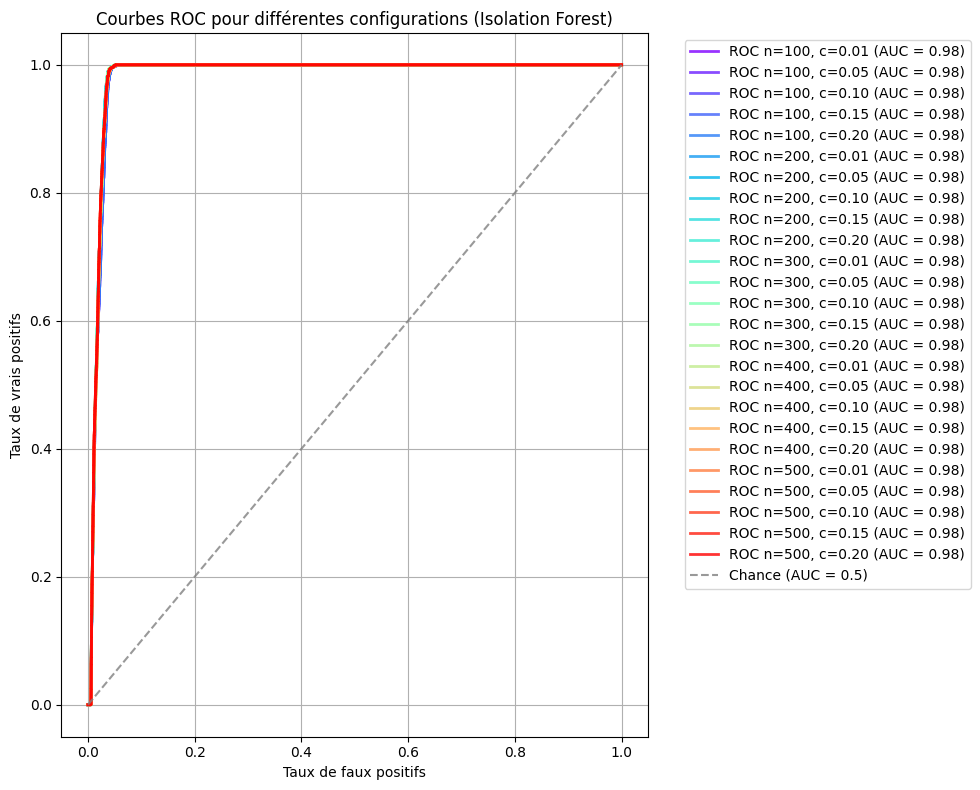


Résultats pour chaque configuration:

n_estimators=100, contamination=0.01
Accuracy: 0.9709
Precision: 0.3263
Recall: 0.1272
F1-score: 0.1831
AUC: 0.9820

n_estimators=100, contamination=0.05
Accuracy: 0.9667
Precision: 0.4239
Recall: 0.8258
F1-score: 0.5602
AUC: 0.9820

n_estimators=100, contamination=0.10
Accuracy: 0.9257
Precision: 0.2567
Recall: 1.0000
F1-score: 0.4086
AUC: 0.9820

n_estimators=100, contamination=0.15
Accuracy: 0.8757
Precision: 0.1711
Recall: 1.0000
F1-score: 0.2923
AUC: 0.9820

n_estimators=100, contamination=0.20
Accuracy: 0.8257
Precision: 0.1284
Recall: 1.0000
F1-score: 0.2275
AUC: 0.9820

n_estimators=200, contamination=0.01
Accuracy: 0.9709
Precision: 0.3277
Recall: 0.1277
F1-score: 0.1838
AUC: 0.9834

n_estimators=200, contamination=0.05
Accuracy: 0.9692
Precision: 0.4483
Recall: 0.8733
F1-score: 0.5925
AUC: 0.9834

n_estimators=200, contamination=0.10
Accuracy: 0.9257
Precision: 0.2567
Recall: 1.0000
F1-score: 0.4086
AUC: 0.9834

n_estimators=200, contami

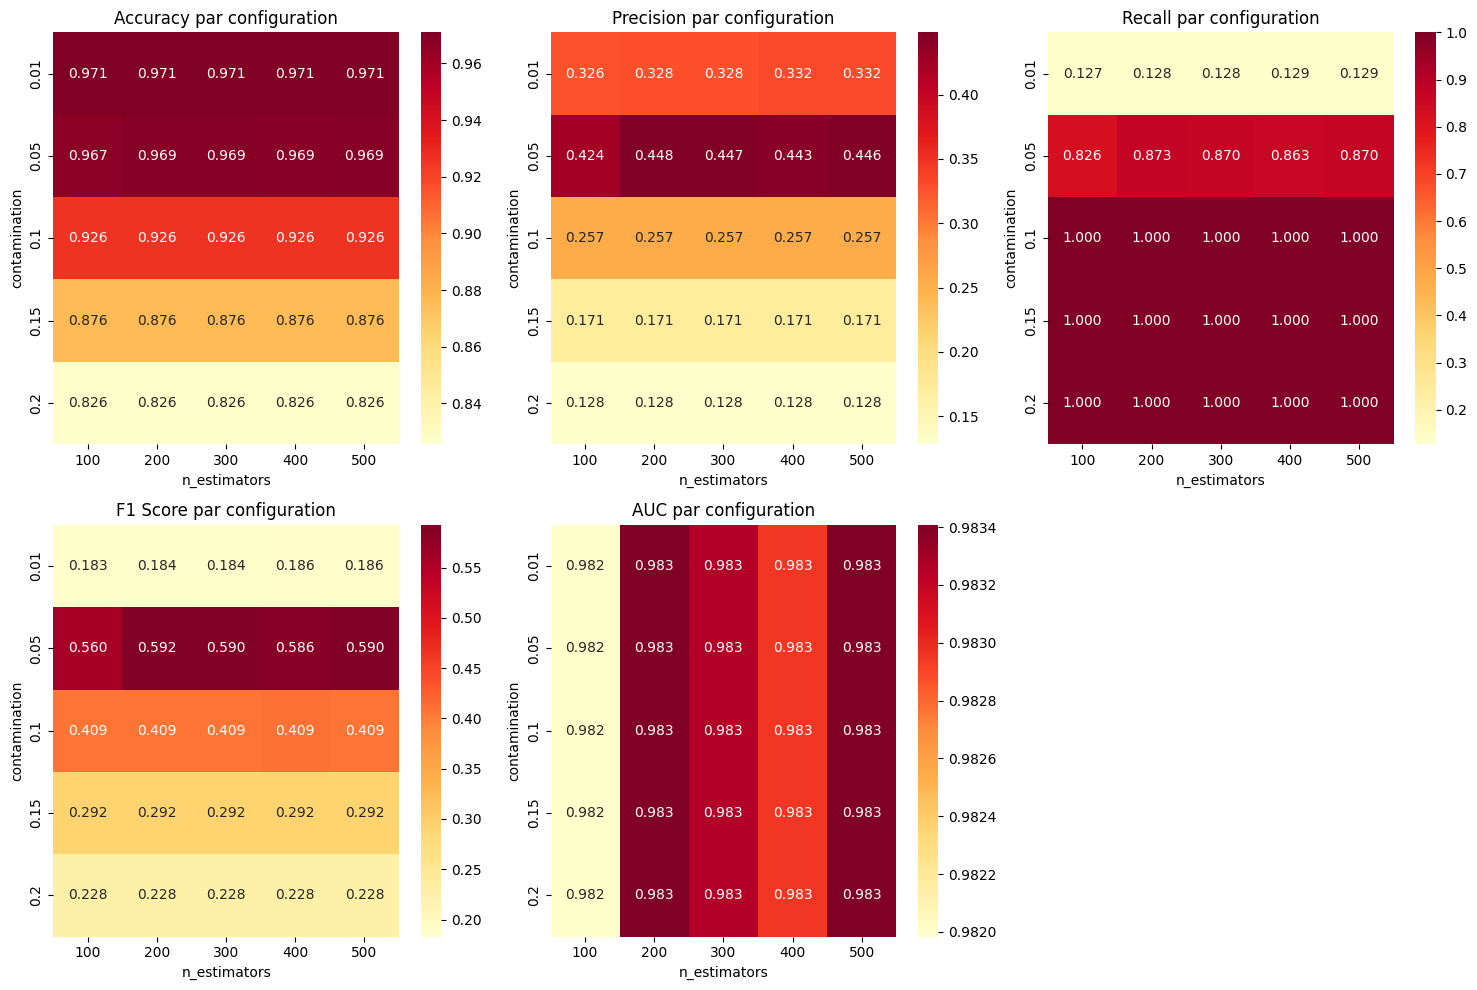

In [33]:
# Function to convert IsolationForest predictions to binary format
def convert_predictions(y_pred):
    # Convert -1 (anomaly) to 1 and 1 (normal) to 0
    return np.where(y_pred == -1, 1, 0)

# Initialize lists to store results
if_results = []

# Créer une figure pour les courbes ROC
plt.figure(figsize=(10, 8))
contamination_values = [0.01, 0.05, 0.1, 0.15, 0.2]
n_estimators_values = [100, 200, 300, 400, 500]
colors = plt.cm.rainbow(np.linspace(0, 1, len(contamination_values) * len(n_estimators_values)))

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

color_idx = 0
# Test different combinations of parameters
for n_estimators in n_estimators_values:
    for contamination in contamination_values:
        print(f"Testing n_estimators={n_estimators}, contamination={contamination}")
        
        # Initialize the Isolation Forest
        if_model = IsolationForest(
            n_estimators=n_estimators,
            contamination=contamination,
            random_state=42,
            n_jobs=-1
        )
        
        # Fit and predict on training data
        y_pred = convert_predictions(if_model.fit_predict(X_train_scaled))
        decision_scores = -if_model.score_samples(X_train_scaled)
        
        # Calculate metrics
        accuracy = accuracy_score(y_train, y_pred)
        precision = precision_score(y_train, y_pred)
        recall = recall_score(y_train, y_pred)
        f1 = f1_score(y_train, y_pred)
        
        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_train, decision_scores)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, color=colors[color_idx],
                label=f'ROC n={n_estimators}, c={contamination:.2f} (AUC = {roc_auc:.2f})',
                lw=2, alpha=0.8)
        color_idx += 1
        
        # Store results
        if_results.append({
            "n_estimators": n_estimators,
            "contamination": contamination,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "AUC": roc_auc
        })

# Finaliser le graphique ROC
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.8,
         label='Chance (AUC = 0.5)')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbes ROC pour différentes configurations (Isolation Forest)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print results and find best configuration
print("\nRésultats pour chaque configuration:")
for result in if_results:
    print(f"\nn_estimators={result['n_estimators']}, contamination={result['contamination']:.2f}")
    print(f"Accuracy: {result['Accuracy']:.4f}")
    print(f"Precision: {result['Precision']:.4f}")
    print(f"Recall: {result['Recall']:.4f}")
    print(f"F1-score: {result['F1 Score']:.4f}")
    print(f"AUC: {result['AUC']:.4f}")

# Find best configuration based on AUC
best_result = max(if_results, key=lambda x: x['AUC'])
print(f"\nMeilleure configuration:")
print(f"n_estimators: {best_result['n_estimators']}")
print(f"contamination: {best_result['contamination']:.2f}")
print(f"AUC: {best_result['AUC']:.4f}")

# Visualiser l'évolution des métriques
plt.figure(figsize=(15, 10))

# Créer un subplot pour chaque métrique
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
for idx, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, idx)
    
    # Créer une matrice pour le heatmap
    heatmap_data = np.zeros((len(contamination_values), len(n_estimators_values)))
    for i, cont in enumerate(contamination_values):
        for j, n_est in enumerate(n_estimators_values):
            result = next(r for r in if_results 
                         if r['contamination'] == cont and r['n_estimators'] == n_est)
            heatmap_data[i, j] = result[metric]
    
    # Tracer le heatmap
    sns.heatmap(heatmap_data, 
                xticklabels=n_estimators_values,
                yticklabels=contamination_values,
                annot=True, 
                fmt='.3f',
                cmap='YlOrRd')
    plt.xlabel('n_estimators')
    plt.ylabel('contamination')
    plt.title(f'{metric} par configuration')

plt.tight_layout()
plt.show()

### On constate qu'en jouant avec le paramètre contamination entre 0.05 et 0.1, on peut choisir d'ajuster le recall. On peut détecter toutes les anomalies sans exception mais les faux positifs restent importants.

In [52]:
# On force le choix pour avoir un bon recall
best_result['n_estimators'] = 200
best_result['contamination'] = 0.07


=== VALIDATION FINALE SUR L'ENSEMBLE DE TEST ===

Résultats sur l'ensemble de test:
Accuracy: 0.9555
Precision: 0.3653
Recall: 0.9959
F1-score: 0.5346
AUC-ROC: 0.9835

Rapport de classification détaillé:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     18568
           1       0.37      1.00      0.53       489

    accuracy                           0.96     19057
   macro avg       0.68      0.98      0.76     19057
weighted avg       0.98      0.96      0.97     19057



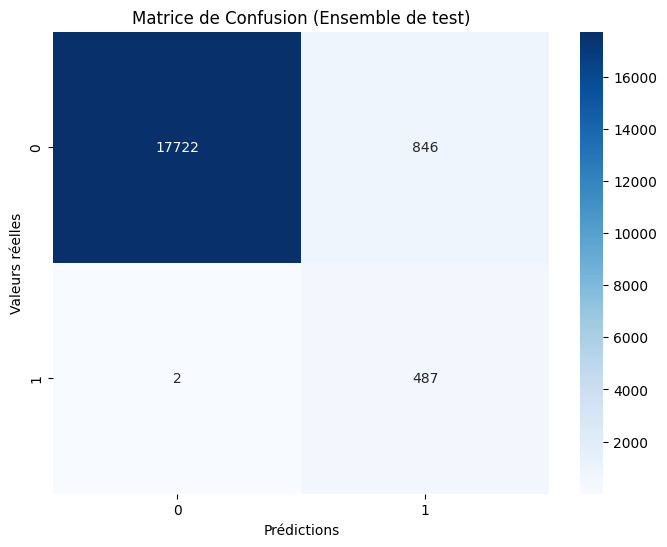

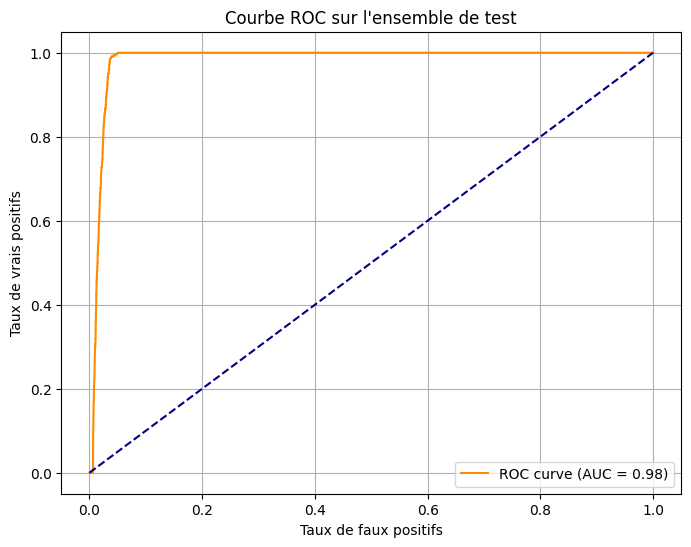

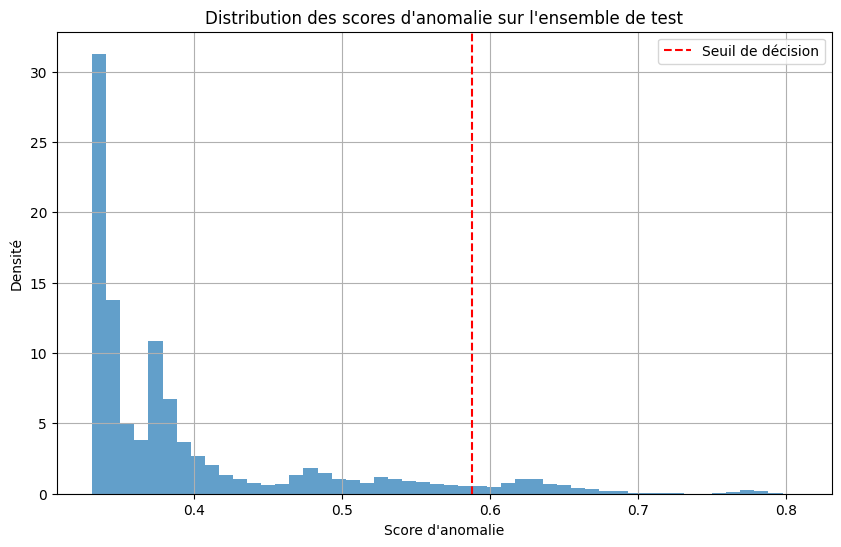

In [51]:
# =============== VALIDATION FINALE ===============
print("\n=== VALIDATION FINALE SUR L'ENSEMBLE DE TEST ===")

# Initialiser le modèle Isolation Forest avec la meilleure configuration
best_if = IsolationForest(
    n_estimators=best_result['n_estimators'],
    contamination=best_result['contamination'],
    random_state=42,
    n_jobs=-1
)

# Entraîner le modèle
best_if.fit(X_train_scaled)

# Prédire sur l'ensemble de test
y_pred_test = convert_predictions(best_if.predict(X_test_scaled))
decision_scores_test = -best_if.score_samples(X_test_scaled)

# Calculer les métriques d'évaluation
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

# Calculer la courbe ROC et l'AUC pour l'ensemble de test
fpr_test, tpr_test, _ = roc_curve(y_test, decision_scores_test)
roc_auc_test = auc(fpr_test, tpr_test)

# Afficher les résultats de validation
print(f"\nRésultats sur l'ensemble de test:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc_test:.4f}")

# Afficher le rapport de classification détaillé
print("\nRapport de classification détaillé:")
print(classification_report(y_test, y_pred_test))

# Créer et afficher la matrice de confusion
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion (Ensemble de test)')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.show()

# Tracer la courbe ROC finale sur l'ensemble de test
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='darkorange',
         label=f'ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC sur l\'ensemble de test')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Visualisation de la distribution des scores de décision
plt.figure(figsize=(10, 6))
plt.hist(decision_scores_test, bins=50, density=True, alpha=0.7)
plt.axvline(np.percentile(decision_scores_test, 100*(1-best_result['contamination'])),
            color='r', linestyle='--', label='Seuil de décision')
plt.xlabel('Score d\'anomalie')
plt.ylabel('Densité')
plt.title('Distribution des scores d\'anomalie sur l\'ensemble de test')
plt.legend()
plt.grid(True)
plt.show()